# Examples for Chapter 8

In [2]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%matplotlib inline

## Algorithms for simple cost functions

### K-means clustering

In [ ]:
run scripts/kmeans -p [1,2,3,4] -k 8 imagery/AST_20070501_pca.tif

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_kmeans.tif -c \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_1.eps'

#### K-means on GEE

In [ ]:
import ee
from ipyleaflet import (Map,DrawControl,TileLayer)
ee.Initialize()

image = ee.Image('users/mortcanty/supervisedclassification/AST_20070501_pca').select(0,1,2,3)
region = image.geometry()

training = image.sample(region=region,scale=15,numPixels=100000)
clusterer = ee.Clusterer.wekaKMeans(8)
trained = clusterer.train(training)
  
clustered = image.cluster(trained)

In [ ]:
# function for overlaying tiles onto a map
def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_url_template =  "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
  return tile_url_template.format(**map_id)

# display the default base map and overlay the clustered image
center = list(reversed(region.centroid().getInfo()['coordinates']))
m = Map(center=center, zoom=11)

jet = 'black,blue,cyan,yellow,red'
m.add_layer(TileLayer(url=GetTileLayerUrl(
        clustered.select('cluster').visualize(min=0, max=6, palette= jet, opacity = 1.0)
    )
))

m

#### K-means with Tensorflow

In [ ]:
import os
import numpy as np
import tensorflow as tf
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly,GDT_Byte

tf.logging.set_verbosity('ERROR')

# read image data
infile = 'imagery/AST_20070501_pca.tif'
pos = [1,2,3,4]
gdal.AllRegister()
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount    
if pos is not None:
    bands = len(pos)
else:
    pos = range(1,bands+1)
G = np.zeros((cols*rows,bands))      
k = 0
for b in pos:
    band = inDataset.GetRasterBand(b)
    band = band.ReadAsArray(0,0,cols,rows)
    G[:,k] = np.ravel(band)
    k += 1 
inDataset = None    
# define an input function
def input_fn():          
    return tf.train.limit_epochs(
        tf.convert_to_tensor(G, dtype=tf.float32), 
        num_epochs=1)

In [ ]:
num_iterations = 10
num_clusters = 8
# create K-means clusterer
kmeans = tf.contrib.factorization.KMeansClustering(
    num_clusters=num_clusters, use_mini_batch=False)
# train it
for _ in xrange(num_iterations):
    kmeans.train(input_fn)
    print 'score: %f'%kmeans.score(input_fn)
# map the input points to their clusters
labels = np.array(
    list(kmeans.predict_cluster_index(input_fn)))
# write to disk
path = os.path.dirname(infile)
basename = os.path.basename(infile)
root, ext = os.path.splitext(basename)
outfile = path+'/'+root+'_kmeans'+ext 
driver = gdal.GetDriverByName('GTiff')    
outDataset = driver.Create(outfile,cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)),0,0) 
outBand.FlushCache() 
outDataset = None
print 'result written to: '+outfile 

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_kmeans.tif -c

### Kernel K-means clustering

In [ ]:
run scripts/kkmeans -p [1,2,3,4] -n 1 -k 8 imagery/AST_20070501_pca.tif 

In [ ]:
%run scripts/dispms -f imagery/AST_20070501_pca_kkmeans.tif -c \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_2.eps'

### Extended K-mean clustering

In [ ]:
run scripts/ekmeans -b 1 imagery/AST_20070501_pca.tif

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_ekmeans.tif -c \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_3.eps'

### Agglomerative hierarchical clustering

In [ ]:
run scripts/hcl -h

------- Hierarchical clustering ---------
Wed Oct 10 11:59:07 2018
Input: imagery/AST_20070501_pca.tif
Clusters: 8
Samples: 2000
classifying...


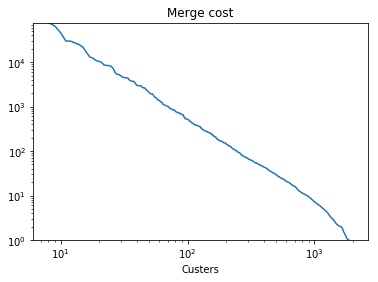

result written to: imagery/AST_20070501_pca_hcl.tif
elapsed time: 29.1420390606


In [4]:
run scripts/hcl -p [1,2,3,4] -k 8 -s 2000 imagery/AST_20070501_pca.tif

In [ ]:
run scripts/dispms -f imagery/may0107pca_hcl.tif -c

### Gaussian mixture clustering

In [ ]:
run scripts/em -h

In [2]:
run scripts/em -p [1,2,3,4] -K 8 imagery/AST_20070501_pca.tif

--------------------------
     EM clustering
--------------------------
infile:   imagery/AST_20070501_pca.tif
clusters: 8
T0:       0.500000
beta:     0.500000
scale:    2
running EM on 62500 pixel vectors
em iteration 0: dU: 0.415184 loglike: -142021.072223
em iteration 10: dU: 0.981655 loglike: -37258.295438
em iteration 20: dU: 0.983476 loglike: -18470.380081
em iteration 30: dU: 0.693432 loglike: -14516.862013
em iteration 40: dU: 0.343456 loglike: -14911.751013
em iteration 50: dU: 0.117420 loglike: -15065.273913
em iteration 60: dU: 0.085451 loglike: -14923.871070
em iteration 70: dU: 0.061931 loglike: -14882.249958
em iteration 80: dU: 0.029324 loglike: -14936.641232
em iteration 90: dU: 0.011158 loglike: -14947.340889
em iteration 100: dU: 0.003687 loglike: -14947.280518
em iteration 110: dU: 0.001227 loglike: -14946.225365
running EM on 250000 pixel vectors
em iteration 0: dU: 1.000000 loglike: -226525.710487
em failed


In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_em.tif -c -d [0,0,400,400] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_5.eps'

### Benchmark

In [ ]:
from osgeo.gdalconst import GDT_Float32

image = np.zeros((800,800,3))
b = 2.0
image[99:699 ,299:499 ,:] = b
image[299:499 ,99:699 ,:] = b
image[299:499 ,299:499 ,:] = 2*b
n1 = np.random.randn(800,800)
n2 = np.random.randn(800,800)
n3 = np.random.randn(800,800)
image[:,:,0] += n1
image[:,:,1] += n2+n1
image[:,:,2] += n3+n1/2+n2/2
driver = gdal.GetDriverByName('GTiff')    
outDataset = driver.Create('imagery/toy.tif',
                           800,800,3,GDT_Float32)  
for k in range(3):        
    outBand = outDataset.GetRasterBand(k+1)
    outBand.WriteArray(image[:,:,k],0,0) 
    outBand.FlushCache() 
outDataset = None                     

In [ ]:
run scripts/dispms -f 'imagery/toy.tif' -e 3 -p [1,2,3]

In [ ]:
run scripts/ex3_2 imagery/toy.tif

In [ ]:
run scripts/hcl -k 3 imagery/toy.tif

In [ ]:
run scripts/em -K 3 -s 1.0 imagery/toy.tif

In [ ]:
run scripts/dispms -f imagery/toy_em.tif -c -F imagery/toy_hcl.tif -C

### Kohonen SOM

In [ ]:
run scripts/som -c 6  imagery/AST_20070501

In [ ]:
run scripts/dispms -f imagery/AST_20070501_som -e 4 -p [1,2,3] -d [0,0,400,400] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_9.eps'

### Mean shift segmentation

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca.tif -p [1,2,3] -e 4 -d [300,450,400,400]

In [ ]:
run scripts/meanshift -p [1,2,3,4] -d [500,450,200,200] -s 15 -r 30 -m 10 imagery/AST_20070501_pca.tif

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_meanshift.tif -p [1,2,3] -e 4  \
-F imagery/AST_20070501_pca.tif -P [1,2,3] -E 4 -D [500,450,200,200] \
%-s  '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_10.eps'

In [ ]:
run scripts/dispms -f imagery/AST_20070501_pca_meanshift.tif -p [1,2,3] -e 3 \
-F imagery/AST_20070501_pca_meanshift.tif -P [6,6,6] -E 3 -o 0.4

### Toy image for Exercise 2

In [3]:
from osgeo.gdalconst import GDT_Float32
import numpy as np
import gdal

image = np.zeros((400,400,2))
n = np.random.randn(400,400)
n1 = 8*np.random.rand(400,400)-4
image[:,:,0] = n1+8
image[:,:,1] = n1**2+0.3*np.random.randn(400,400)+8
image[:200,:,0] = np.random.randn(200,400)/2+8
image[:200,:,1] = np.random.randn(200,400)+14
driver = gdal.GetDriverByName('GTIFF')
outDataset = driver.Create('imagery/toy.tif',400,400,3,GDT_Float32)
for k in range(2):
    outBand= outDataset.GetRasterBand(k+1)
    outBand.WriteArray(image[:,:,k],0,0) 
    outBand.FlushCache() 
outDataset = None    

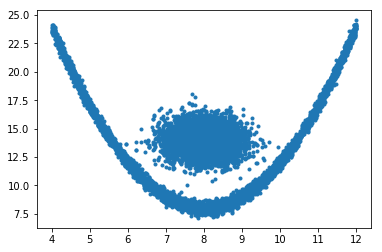

In [4]:
run scripts/scatterplot -s '/home/mort/LaTeX/new projects/CRC4/Chapter8/fig8_11.eps' imagery/toy.tif imagery/toy.tif 1 2